# Pascal VOC2012
Le jeu de données Pascal VOC 2012 est une collection précieuse et polyvalente de données d'images annotées utilisée dans le domaine de la vision par ordinateur. Cette base de données renferme un ensemble diversifié d'images provenant de diverses catégories, notamment des objets, des animaux, des véhicules et des scènes urbaines. Chaque image est associée à des annotations détaillées qui identifient et encadrent les objets présents, permettant ainsi l'entraînement et l'évaluation précis des modèles de détection d'objets et de segmentation sémantique. Pascal VOC 2012 est reconnu pour sa qualité et sa variété, faisant de lui un choix privilégié pour la recherche et le développement de méthodes avancées en vision par ordinateur et en apprentissage automatique.

1. Télécharger la formation, la validation, les données de test et le kit VOCdevkit

In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing


import xml.etree.ElementTree as ET


from torch_snippets import *
import torch
import torchvision


import cupy as cp
import cupy

In [2]:
BASE_PATH = os.path.join("VOCdevkit","VOC2012")
XML_PATH = os.path.join(BASE_PATH, "Annotations")
IMG_PATH = os.path.join(BASE_PATH, "JPEGImages")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]


## **Extraire des informations des fichiers xml**

In [3]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # chemin d'accès au fichier image tel que décrit dans le fichier xml
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id
        self.image_id = self._root.find("filename").text
        # noms des classes contenues dans le fichier xml
        self.names = self._get_names()
        # coordonnées des boîtes de délimitation
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""

        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

## **Faire un cadre de données à partir des informations extraites**

In [4]:
def xml_files_to_df(xml_files):

    """"Return pandas dataframe from list of XML files."""

    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}

    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()

    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,names,boxes,xml_path,img_path
0,2007_000027.jpg,person,"[174, 101, 349, 351]",VOCdevkit\VOC2012\Annotations\2007_000027.xml,VOCdevkit\VOC2012\JPEGImages\2007_000027.jpg
1,2007_000032.jpg,aeroplane,"[104, 78, 375, 183]",VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg
2,2007_000032.jpg,aeroplane,"[133, 88, 197, 123]",VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg
3,2007_000032.jpg,person,"[195, 180, 213, 229]",VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg
4,2007_000032.jpg,person,"[26, 189, 44, 238]",VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg


---

In [5]:
# check values for per class
df['names'].value_counts()

names
person         17401
chair           3056
car             2492
dog             1598
bottle          1561
cat             1277
bird            1271
pottedplant     1202
sheep           1084
boat            1059
aeroplane       1002
tvmonitor        893
sofa             841
bicycle          837
horse            803
motorbike        801
diningtable      800
cow              771
train            704
bus              685
Name: count, dtype: int64

In [6]:
# remove .jpg extension from image_id
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

,names,boxes,xml_path,img_path,img_id
0,person,"[174, 101, 349, 351]",VOCdevkit\VOC2012\Annotations\2007_000027.xml,VOCdevkit\VOC2012\JPEGImages\2007_000027.jpg,2007_000027
1,aeroplane,"[104, 78, 375, 183]",VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg,2007_000032
2,aeroplane,"[133, 88, 197, 123]",VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg,2007_000032
3,person,"[195, 180, 213, 229]",VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg,2007_000032
4,person,"[26, 189, 44, 238]",VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg,2007_000032


In [7]:
# les classes doivent être sous forme d'int, nous utilisons donc LabelEncoder pour cette tâche
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels'])))

C:\Users\nmadali\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [8]:
classes = df[['names','labels']].value_counts()
classes

names        labels
person       15        17401
chair        9          3056
car          7          2492
dog          12         1598
bottle       5          1561
cat          8          1277
bird         3          1271
pottedplant  16         1202
sheep        17         1084
boat         4          1059
aeroplane    1          1002
tvmonitor    20          893
sofa         18          841
bicycle      2           837
horse        13          803
motorbike    14          801
diningtable  11          800
cow          10          771
train        19          704
bus          6           685
Name: count, dtype: int64

In [9]:
# créer un dictionnaire pour les objets de la classe afin de pouvoir appeler les objets par leurs clés.
classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',11:'diningtable',12:'dog',13:'horse',14:'motorbike',15:'person',16:'pottedplant',17:'sheep',18:'sofa',19:'train',20:'tvmonitor'}

In [10]:
# Les coordonnées de la boîte de délimitation doivent figurer dans des colonnes distinctes.

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype('float32')
df['ymin'] = df['ymin'].astype('float32')
df['xmax'] = df['xmax'].astype('float32')
df['ymax'] = df['ymax'].astype('float32')

C:\Users\nmadali\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [11]:
# supprimer la colonne des noms puisque nous n'en avons plus besoin
df.drop(columns=['names'], inplace=True)
df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,VOCdevkit\VOC2012\Annotations\2007_000027.xml,VOCdevkit\VOC2012\JPEGImages\2007_000027.jpg,2007_000027,15,174.0,101.0,349.0,351.0
1,VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg,2007_000032,1,104.0,78.0,375.0,183.0
2,VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg,2007_000032,1,133.0,88.0,197.0,123.0
3,VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg,2007_000032,15,195.0,180.0,213.0,229.0
4,VOCdevkit\VOC2012\Annotations\2007_000032.xml,VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg,2007_000032,15,26.0,189.0,44.0,238.0


In [12]:
len(df['img_id'].unique())

17125

## **Séparer les données de formation et de validation**

In [13]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-4000:]
train_ids = image_ids[:-4000]
len(train_ids)

13125

In [14]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((5482, 8), (34656, 8))

## **Faire un jeu de données par le module de jeu de données**

In [15]:
image_id=train_ids[0]

records = train_df[train_df['img_id'] == image_id]

image = cv2.imread(f'{IMG_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
rows, cols = image.shape[:2]

boxes = records[['ymin', 'xmin', 'ymax', 'xmax']].values

label = records['labels'].values

In [16]:
image.shape

(500, 486, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


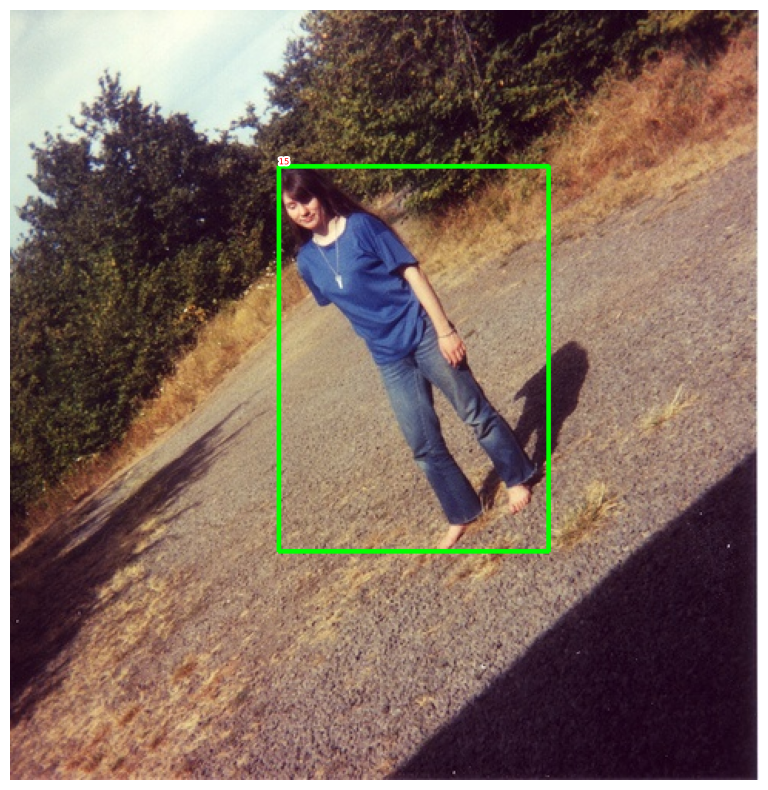

In [23]:
show(image, bbs=boxes[:,[1,0,3,2]], texts=label, sz=10)

# Preprocessing

In [18]:

import  skimage

def preprocess(img, min_size=600, max_size=1000):

    H, W,C = img.shape
    scale1 = min_size / min(H, W)
    scale2 = max_size / max(H, W)
    scale = min(scale1, scale2)

    img =  skimage.transform.resize(img, ( H * scale, W * scale,C), mode='reflect',anti_aliasing=False)

    return img
def resize_bbox(bbox, in_size, out_size):

    bbox = bbox.copy()
    y_scale = float(out_size[0]) / in_size[0]
    x_scale = float(out_size[1]) / in_size[1]
    bbox[:, 0] = y_scale * bbox[:, 0]
    bbox[:, 2] = y_scale * bbox[:, 2]
    bbox[:, 1] = x_scale * bbox[:, 1]
    bbox[:, 3] = x_scale * bbox[:, 3]
    #print(bbox[0, :])
    return bbox

class Transform(object):

    def __init__(self, min_size=600, max_size=1000):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, in_data):
        img, bbox, label = in_data
        H, W,_ = img.shape
        img = preprocess(img)
        o_H, o_W,_ = img.shape
        scale = o_H / H
        bbox = resize_bbox(bbox, (H, W), (o_H, o_W))

        return img, bbox, label, scale




In [19]:
tsf = Transform()

img,  bboxs, label, scale = tsf((image, boxes, label))


In [20]:
bboxs

array([[124.633995, 214.8148  , 433.134   , 430.8642  ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


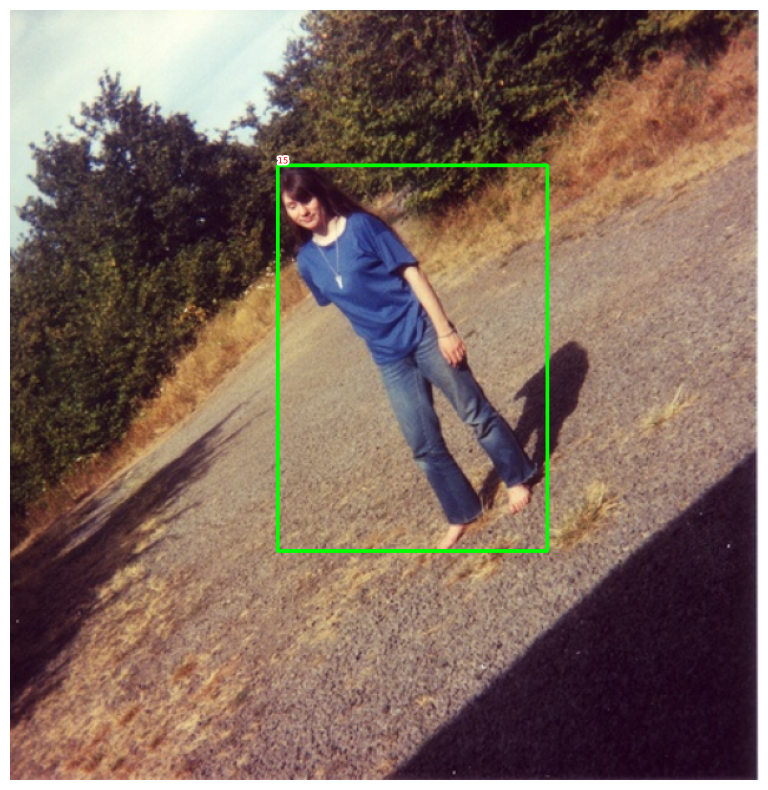

In [24]:

show(img, bbs=bboxs[:,[1,0,3,2]], texts=label, sz=10)

In [25]:
print(image.shape)

(500, 486, 3)

In [26]:
print(img.shape)

(617, 600, 3)

#Anchor Generation

In [27]:

def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):

    py = base_size / 2.
    px = base_size / 2.

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            anchor_base[index, 0] = py - h / 2.
            anchor_base[index, 1] = px - w / 2.
            anchor_base[index, 2] = py + h / 2.
            anchor_base[index, 3] = px + w / 2.
    return anchor_base

In [28]:
anchors = generate_anchor_base()

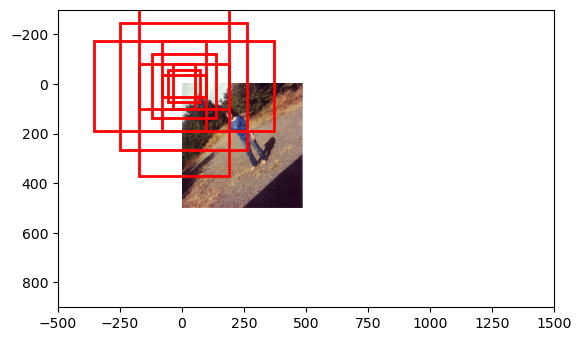

In [29]:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image)
ax.set_xlim([-500,1500])
ax.set_ylim([900,-300])
for i in range(9):
    x1 = anchors[i][0]
    y1 = anchors[i][1]
    x2 = anchors[i][2]
    y2 = anchors[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=2))

In [30]:

def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):

    shift_y = np.arange(0, height * feat_stride, feat_stride)
    shift_x = np.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shift = np.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)

    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor

In [31]:
all_anchor = _enumerate_shifted_anchor(np.array(anchors),16, image.shape[0]//16, image.shape[1]//16)

In [32]:
all_anchor.shape

(8370, 4)

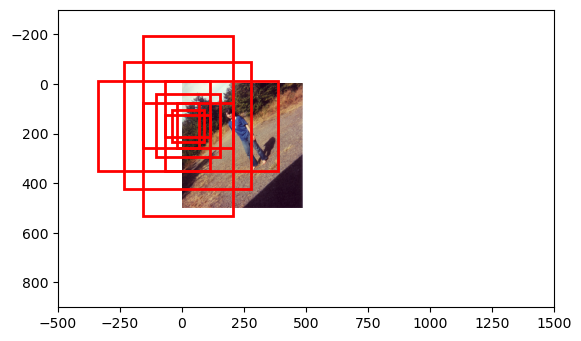

In [33]:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image)
ax.set_xlim([-500,1500])
ax.set_ylim([900,-300])

shift=40

for i in range(shift*9,(shift+1)*9):
    x1 = all_anchor[i][0]
    y1 = all_anchor[i][1]
    x2 = all_anchor[i][2]
    y2 = all_anchor[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=2))

In [34]:

def _get_inside_index(anchor, H, W):

    index_inside = np.where(
        (anchor[:, 0] >= 0) & #y1
        (anchor[:, 1] >= 0) & #x1
        (anchor[:, 2] <= H) & #y2
        (anchor[:, 3] <= W)   #x2
    )[0]
    return index_inside

In [35]:

def bbox_iou(bbox_a, bbox_b):

    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        raise IndexError


    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])

    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

In [36]:

def bbox2loc(src_bbox, dst_bbox):
    """Encodes the source and the destination bounding boxes to "loc".

    Given bounding boxes, this function computes offsets and scales
    to match the source bounding boxes to the target bounding boxes.

    Args:
        src_bbox (array): An image coordinate array whose shape is
            :math:`(R, 4)`. :math:`R` is the number of bounding boxes.
            These coordinates are :math:`p_{ymin}, p_{xmin}, p_{ymax}, p_{xmax}`.
        dst_bbox (array): An image coordinate array whose shape is
            :math:`(R, 4)`. These coordinates are
            :math:`g_{ymin}, g_{xmin}, g_{ymax}, g_{xmax}`.

    Returns:
        array:
        Bounding box offsets and scales from `src_bbox` to `dst_bbox`. \
        This has shape :math:`(R, 4)`.
        The second axis contains four values :math:`t_y, t_x, t_h, t_w`.

    """

    height = src_bbox[:, 2] - src_bbox[:, 0]
    width = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_y = src_bbox[:, 0] + 0.5 * height
    ctr_x = src_bbox[:, 1] + 0.5 * width

    base_height = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_width = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_y = dst_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = dst_bbox[:, 1] + 0.5 * base_width


    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)

    loc = np.vstack((dy, dx, dh, dw)).transpose()
    return loc

In [37]:

def _unmap(data, count, index, fill=0):


    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=data.dtype)
        ret.fill(fill)
        ret[index] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=data.dtype)
        ret.fill(fill)
        ret[index, :] = data

    return ret

In [38]:


class AnchorTargetCreator(object):
    """Assign the ground truth bounding boxes to anchors.

    Assigns the ground truth bounding boxes to anchors for training Region Proposal Networks.

    Offsets and scales to match anchors to the ground truth are
    calculated using the encoding scheme of bbox2loc.

    Args:
        n_sample (int): The number of regions to produce.
        pos_iou_thresh (float): Anchors with IoU above this threshold will be assigned as positive.
        neg_iou_thresh (float): Anchors with IoU below this threshold will be assigned as negative.
        pos_ratio (float): Ratio of positive regions in the sampled regions.

    """

    def __init__(self, n_sample=256, pos_iou_thresh=0.7, neg_iou_thresh=0.3, pos_ratio=0.5):
        self.n_sample = n_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh = neg_iou_thresh
        self.pos_ratio = pos_ratio

    def __call__(self, bbox, anchor, img_size):


        img_H, img_W = img_size

        n_anchor = len(anchor)
        inside_index = _get_inside_index(anchor, img_H, img_W)
        anchor = anchor[inside_index]

        argmax_ious, label = self._create_label(inside_index, anchor, bbox)


        loc = bbox2loc(anchor, bbox[argmax_ious])


        label = _unmap(label, n_anchor, inside_index, fill=-1)
        loc = _unmap(loc, n_anchor, inside_index, fill=0)

        return loc, label

    def _create_label(self, inside_index, anchor, bbox):

        label = np.empty((len(inside_index),), dtype=np.int32)
        label.fill(-1)

        argmax_ious, max_ious, gt_argmax_ious = self._calc_ious(anchor, bbox, inside_index)


        label[max_ious < self.neg_iou_thresh] = 0


        label[gt_argmax_ious] = 1


        label[max_ious >= self.pos_iou_thresh] = 1


        n_pos = int(self.pos_ratio * self.n_sample)
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label[disable_index] = -1


        n_neg = self.n_sample - np.sum(label == 1)
        neg_index = np.where(label == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
            label[disable_index] = -1

        return argmax_ious, label


    def _calc_ious(self, anchor, bbox, inside_index):

        ious = bbox_iou(anchor, bbox)

        argmax_ious = ious.argmax(axis=1)

        max_ious = ious[np.arange(len(inside_index)), argmax_ious]


        gt_argmax_ious = ious.argmax(axis=0)

        gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]

        gt_argmax_ious = np.where(ious == gt_max_ious)[0]

        return argmax_ious, max_ious, gt_argmax_ious

In [39]:
class RegionProposalNetwork(nn.Module):
    """Region Proposal Network introduced in Faster R-CNN.

    Args:
        in_channels (int): The channel size of input.
        mid_channels (int): The channel size of the intermediate tensor.
        ratios (list of floats): This is ratios of width to height of
            the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            :obj:`anchor_scales` and the original area of the reference
            window.
        feat_stride (int): Stride size after extracting features from an
            image.

        proposal_creator_params (dict): Key valued paramters for
            :class:`model.utils.creator_tools.ProposalCreator`.

    """

    def __init__(
            self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
            anchor_scales=[8, 16, 32], feat_stride=16,
            proposal_creator_params=dict(),
    ):
        super(RegionProposalNetwork, self).__init__()

        model = torchvision.models.vgg16(pretrained=True)
        features=list(model.features)[:30]
        self.features =nn.Sequential(*features)



        self.anchor_base = generate_anchor_base(anchor_scales=anchor_scales, ratios=ratios)
        self.feat_stride = feat_stride

        n_anchor = self.anchor_base.shape[0]
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        self.normal_init(self.conv1, 0, 0.01)
        self.normal_init(self.score, 0, 0.01)
        self.normal_init(self.loc, 0, 0.01)

    def normal_init(self,m, mean, stddev, truncated=False):

        if truncated:
            m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
        else:
            m.weight.data.normal_(mean, stddev)
            m.bias.data.zero_()
    def forward(self, x):

        img_size=x.shape

        x=self.features(x)
        n, _, hh, ww = x.shape
        anchor = _enumerate_shifted_anchor(np.array(self.anchor_base), self.feat_stride, hh, ww)

        n_anchor = anchor.shape[0] // (hh * ww)
        h = F.relu(self.conv1(x))

        rpn_locs = self.loc(h)

        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)


        return rpn_locs, rpn_scores, anchor

In [40]:
anchor_target_creator = AnchorTargetCreator()
rpn = RegionProposalNetwork().to(device)
optimizer = optim.SGD(rpn.parameters(), lr=1e-3)
n_epochs = 10
log = Report(n_epochs)

C:\Users\nmadali\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nmadali\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
data=torch.from_numpy(image).unsqueeze(0).permute(0,3,1,2).cuda()

In [42]:
data.shape

torch.Size([1, 3, 500, 486])

In [43]:
rpn_locs, rpn_scores, anchor = rpn(data)

In [44]:
rpn_locs.shape, rpn_scores.shape, anchor.shape

(torch.Size([1, 8370, 4]), torch.Size([1, 8370, 2]), (8370, 4))

In [45]:
gt_rpn_loc, gt_rpn_label = anchor_target_creator( boxes, anchor, image.shape[:2])

In [46]:
gt_rpn_loc.shape, gt_rpn_label.shape

((8370, 4), (8370,))

In [47]:

def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) +
         (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()

def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = torch.zeros(gt_loc.shape).cuda()
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation,
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss


In [48]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [49]:
for epoch in range(n_epochs):

    _n = len(train_ids)
    for ix,image_id in enumerate(train_ids) :




        records = train_df[train_df['img_id'] == image_id]

        image = cv2.imread(f'{IMG_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['ymin', 'xmin', 'ymax', 'xmax']].values

        label = records['labels'].values

        image,  boxes, label, scale = tsf((image, boxes, label))

        #img,  boxes, label, scale = tsf((image, boxes, label))

        data=torch.from_numpy(image).unsqueeze(0).permute(0,3,1,2).cuda()
        data=normalize(data)
        rpn.train()

        optimizer.zero_grad()
        rpn_locs, rpn_scores, anchor = rpn(data)
        gt_rpn_loc, gt_rpn_label = anchor_target_creator( boxes, anchor, image.shape[:2])

        gt_rpn_label = torch.from_numpy(gt_rpn_label).cuda().long()
        gt_rpn_loc = torch.from_numpy(gt_rpn_loc).cuda()

        rpn_cls_loss = F.cross_entropy(rpn_scores[0], gt_rpn_label.cuda(), ignore_index=-1)
        rpn_loc_loss = _fast_rcnn_loc_loss( rpn_locs[0], gt_rpn_loc, gt_rpn_label.data,  3.)
        _, _clss = rpn_scores[0].max(-1)
        accs = (_clss==gt_rpn_label)[gt_rpn_label != -1].cpu().numpy().mean()
        loss=rpn_cls_loss+rpn_loc_loss
        loss.backward()
        optimizer.step()

        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=rpn_loc_loss.item(),
                   trn_regr_loss=rpn_cls_loss.item(),trn_acc=accs, end='\r')

    _n = len(valid_ids)
    for ix,image_id in enumerate(valid_ids) :
        records = valid_df[valid_df['img_id'] == image_id]

        image = cv2.imread(f'{IMG_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['ymin', 'xmin', 'ymax', 'xmax']].values

        label = torch.from_numpy(records['labels'].values)
        image,  boxes, label, scale = tsf((image, boxes, label))

        data=torch.from_numpy(image).unsqueeze(0).permute(0,3,1,2).cuda()
        data=normalize(data)

        with torch.no_grad():
            rpn.eval()
            _rpn_locs, rpn_scores, anchor = rpn(data)
            gt_rpn_loc, gt_rpn_label = anchor_target_creator( boxes, anchor, image.shape[:2])

            gt_rpn_label = torch.from_numpy(gt_rpn_label).cuda().long()
            gt_rpn_loc = torch.from_numpy(gt_rpn_loc).cuda()

            rpn_cls_loss = F.cross_entropy(rpn_scores[0], gt_rpn_label.cuda(), ignore_index=-1)
            rpn_loc_loss = _fast_rcnn_loc_loss(_rpn_locs[0], gt_rpn_loc, gt_rpn_label.data,  3.)


            loss=rpn_cls_loss+rpn_loc_loss
            _, _clss = rpn_scores[0] .max(-1)
            accs = (_clss==gt_rpn_label)[gt_rpn_label != -1].cpu().numpy().mean()
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=rpn_loc_loss.item(),
                val_regr_loss=rpn_cls_loss.item(),
                val_acc=accs, end='\r')

torch.save(rpn.state_dict(), 'rpn.pth')
# Tracer les métriques de formation et de validation
log.plot_epochs('trn_loss,val_loss'.split(','))

EPOCH: 8.865  trn_loss: 0.120  trn_loc_loss: 0.009  trn_regr_loss: 0.111  trn_acc: 0.965  (17689.72s - 2264.18s remaining))))

KeyboardInterrupt: 

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:02<00:00, 48.68it/s]


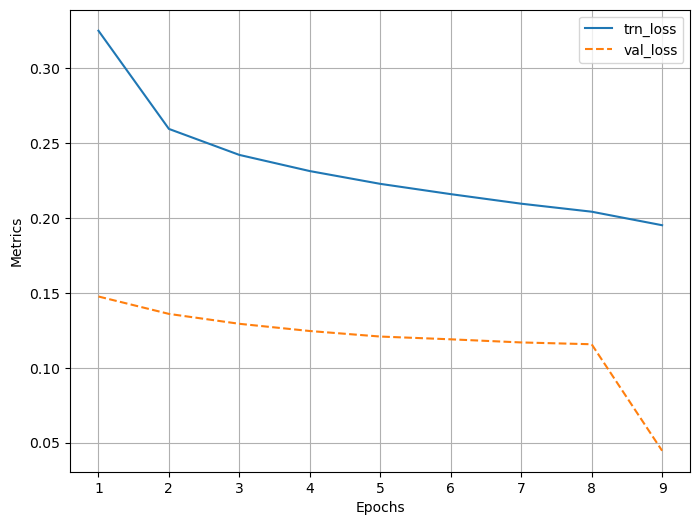

In [50]:
log.plot_epochs('trn_loss,val_loss'.split(','))

In [ ]:
rpn_loc_loss = _fast_rcnn_loc_loss(_rpn_locs[0], gt_rpn_loc, gt_rpn_label.data,  3.)

In [ ]:
anchor.shape

In [ ]:
image_id=valid_ids[0]
records = valid_df[valid_df['img_id'] == image_id]

image = cv2.imread(f'{IMG_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
rows, cols = image.shape[:2]

boxes = records[['ymin', 'xmin', 'ymax', 'xmax']].values

label = torch.from_numpy(records['labels'].values)
image,  boxes, label, scale = tsf((image, boxes, label))




In [ ]:
show(image, bbs=boxes[:,[1,0,3,2]], texts=label, sz=10)

In [ ]:

data=torch.from_numpy(image).unsqueeze(0).permute(0,3,1,2).cuda()
data=normalize(data)

with torch.no_grad():
            rpn.eval()
            _rpn_locs, rpn_scores, anchor = rpn(data)


In [ ]:
img_size=image.shape

In [ ]:
min_size=16
n_train_pre_nms=12000
n_train_post_nms=2000

In [ ]:
#把x,y,w,h转化回x1,y1,x2,y2的形式
def loc2bbox(src_bbox, loc):
    """Decode bounding boxes from bounding box offsets and scales.

    Given bounding box offsets and scales computed by
    :meth:`bbox2loc`, this function decodes the representation to
    coordinates in 2D image coordinates.

    The output is same type as the type of the inputs.

    Args:
        src_bbox (array): A coordinates of bounding boxes.
            Its shape is :math:`(R, 4)`. These coordinates are
            :math:`p_{ymin}, p_{xmin}, p_{ymax}, p_{xmax}`.
        loc (array): An array with offsets and scales.
            The shapes of :obj:`src_bbox` and :obj:`loc` should be same.
            This contains values :math:`t_y, t_x, t_h, t_w`.

    Returns:
        array:
        Decoded bounding box coordinates. Its shape is :math:`(R, 4)`.
        The second axis contains four values
        :`\\hat{g}_{ymin}, \\hat{g}_{xmin}, \\hat{g}_{ymax}, \\hat{g}_{xmax}`.

    """

    if src_bbox.shape[0] == 0:
        return xp.zeros((0, 4), dtype=loc.dtype)

    src_bbox = src_bbox.astype(src_bbox.dtype, copy=False)

    src_height = src_bbox[:, 2] - src_bbox[:, 0]
    src_width = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_height
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_width

    dy = loc[:, 0::4]
    dx = loc[:, 1::4]
    dh = loc[:, 2::4]
    dw = loc[:, 3::4]

    ctr_y = dy * src_height[:, np.newaxis] + src_ctr_y[:, np.newaxis]
    ctr_x = dx * src_width[:, np.newaxis] + src_ctr_x[:, np.newaxis]
    h = np.exp(dh) * src_height[:, np.newaxis]
    w = np.exp(dw) * src_width[:, np.newaxis]

    dst_bbox = np.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4] = ctr_y - 0.5 * h
    dst_bbox[:, 1::4] = ctr_x - 0.5 * w
    dst_bbox[:, 2::4] = ctr_y + 0.5 * h
    dst_bbox[:, 3::4] = ctr_x + 0.5 * w

    return dst_bbox

In [ ]:
loc, score=_rpn_locs[0].cpu().data.numpy(), rpn_scores[0].cpu().data.numpy()

In [ ]:
loc.shape, score.shape

In [ ]:
# Convert anchors into proposal via bbox transformations.
roi = loc2bbox(anchor, loc)
print(roi.shape)

In [ ]:

        # Clip predicted boxes to image.
        # y小于图片高度
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])

        # x小于图片宽度
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])

In [ ]:
roi[:, slice(0, 4, 2)] .shape

In [ ]:
np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]).shape

In [ ]:
 np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]).shape

In [ ]:
print(roi.shape)

In [ ]:


# Remove predicted boxes with either height or width < threshold.
min_size =min_size * scale
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = score[keep]

In [ ]:
print(roi.shape),score .shape

In [ ]:
score.shape

In [ ]:
order = score[:,-1].argsort()[::-1]

In [ ]:
order.shape

In [ ]:


        # Sort all (proposal, score) pairs by score from highest to lowest.
        # Take top pre_nms_topN (e.g. 6000).



order = order[:n_train_pre_nms]
roi = roi[order, :]




In [ ]:
n_train_pre_nms

In [ ]:
score.shape

In [ ]:
len(order)

In [ ]:
roi.shape

In [ ]:
n_train_pre_nms

In [ ]:
keep =torchvision.ops.nms(torch.from_numpy(roi[:,[1,0,3,2]]),scores=torch.from_numpy(score[order,-1]), iou_threshold=0.7)



In [ ]:
keep

In [ ]:
keep = keep[:n_train_post_nms]
roi = roi[keep]

In [ ]:
show(image, bbs=roi[:,[1,0,3,2]], sz=10)

In [ ]:
show(image, bbs=roi[:1,[1,0,3,2]], sz=10)